In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining all constants

KAPPA = 20.0
CHI = 0.65 * 2 * jnp.pi
N_MAX = 233
N_DEFAULT = 43 # assume all measurement are till steady-state, ie around 10/kappa = 400ns
mu_default = jnp.sqrt(N_MAX / N_DEFAULT)
amp_default = 1/mu_default
GAMMA_PHOTON = 1/1500
GAMMA_MEAS = 1/140
INIT_FID = 1 - 1e-4
SNR_SCALE = 1.9
STATE_STD = 1/jnp.sqrt(2)

In [4]:
def SS_meas_pF(
    amp, 
    ts
):
    '''
    Where amp is defined to take values between 0 and 1 like with IBMQ convention
    and ts is a sufficiently large linspace
    returns pF_res with shape (AMPS, TS)
    '''
    amp = amp.reshape(-1, 1)
    ts = ts.reshape(1, -1)
    amp_max = 0.5 * jnp.sqrt(N_MAX * (KAPPA ** 2 + CHI ** 2))
    photon = N_MAX * amp**2
    amp *= amp_max
    separation = (4 * amp * SNR_SCALE / (KAPPA ** 2 + CHI ** 2) 
                  * (CHI * (1. - jnp.exp(-0.5 * KAPPA * ts)) - 0.5 * KAPPA * CHI * ts * jnp.exp(-0.5 * KAPPA * ts)))
    separation_fid = 0.5 * (1. + erf(separation / (2 * jnp.sqrt(2) * STATE_STD)))
    decay_fid = INIT_FID * jnp.exp(-( 
        (GAMMA_PHOTON * photon + GAMMA_MEAS) * ts 
        - 4 * GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-0.5 * KAPPA * ts)) 
        + GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-KAPPA * ts)) 
        )
    )
    pF_res = -jnp.log10(1. - separation_fid * decay_fid)
    max_fidelity = jnp.max(pF_res, axis=-1)
    ts = ts.reshape(-1)
    time_of_max = ts[jnp.argmax(pF_res, axis=-1)]
    return pF_res, max_fidelity, time_of_max

In [5]:
ts = jnp.linspace(0., 0.4, 401)
amp_linspace = jnp.linspace(0.1, 1.0, 46)

batched_pF_res, batched_max_fidelity, batched_times = SS_meas_pF(amp_linspace, ts)

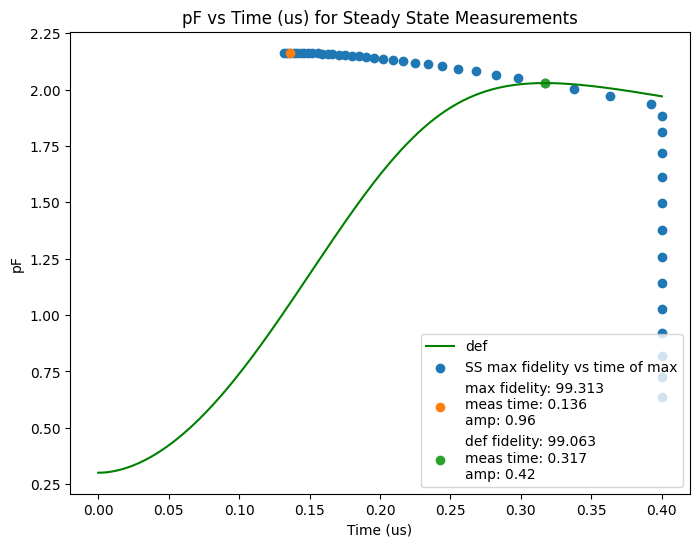

In [6]:
plt.figure(figsize=(8., 6.))
default_amp_ind = jnp.argmin(jnp.abs(amp_linspace - amp_default))
ss_fidelites = 1. - 10**(-batched_max_fidelity)

plt.plot(ts, batched_pF_res[default_amp_ind], label='def', color='green')
plt.scatter(batched_times, batched_max_fidelity, label='SS max fidelity vs time of max')
plt.scatter(
    batched_times[jnp.argmax(batched_max_fidelity)], 
    jnp.max(batched_max_fidelity), 
    label=f'max fidelity: {int(1e5*jnp.max(ss_fidelites)) / 1e3}\nmeas time: {int(1e3*batched_times[jnp.argmax(batched_max_fidelity)]) / 1e3}\namp: {int(1e3*amp_linspace[jnp.argmax(batched_max_fidelity)])/1e3}')
plt.scatter(
    batched_times[default_amp_ind], 
    batched_max_fidelity[default_amp_ind], 
    label=f'def fidelity: {int(1e5*jnp.max(ss_fidelites[default_amp_ind])) / 1e3}\nmeas time: {int(1e3*batched_times[default_amp_ind]) / 1e3}\namp: {int(1e3*amp_linspace[default_amp_ind])/1e3}')
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.title('pF vs Time (us) for Steady State Measurements')
plt.legend()
plt.show()

In [28]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 6.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [29]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 2000 Updates
global update: 100
mean batch reward: [22.3888313  22.45972227 22.51130911 22.38366499 22.17851099 22.51092206
 22.22161673 22.47514275]
mean batch pF: [2.55772358 2.55753204 2.55742066 2.55595714 2.55787498 2.55740414
 2.55722731 2.55824201]
mean batch photon: [32.81804657 32.80141068 32.96388245 32.45057678 33.0609436  32.44016266
 32.52002716 32.94355011]
mean batch photon time: [0.29520274 0.29535969 0.29259045 0.29268646 0.29528456 0.29642611
 0.292305   0.29653697]
mean batch smoothness: [0.00099566 0.0008206  0.00117907 0.00075106 0.001438   0.00092069
 0.00150787 0.00105274]
max reward obtained: [22.8072107  22.82005189 22.80524516 22.78850568 22.80272702 22.80493601
 22.83544524 22.80215046]
pF at max: [2.56180273 2.55950519 2.56446749 2.55649702 2.55584157 2.55124562
 2.55741006 2.5628253 ]
photon at max: [33.71611786 33.81918335 34.77325058 33.38657379 33.57320786 28.49961281
 29.90839005 33.01421356]
photon time of max: [0.34511987 0.2775     

In [30]:
# Extracting Results

metrics = single_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
max_smoothness = metrics["smoothness at max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]
mean_smoothness = metrics["mean batch smoothness"]
std_reward = metrics["std batch reward"]

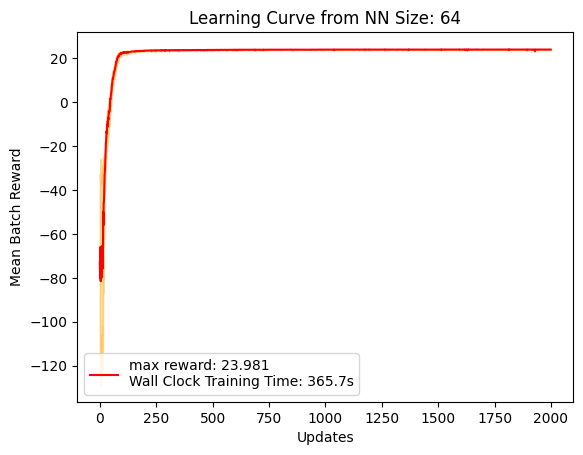

In [31]:
env_ind = 0
update_plot = 2000

x = np.arange(update_plot) # / update_plot * (end - start)
m_plot = mean_rewards[:update_plot, env_ind]
s_plot = std_reward[:update_plot, env_ind]

plt.plot(x, m_plot, label=f'max reward: {int(1e3 * max_rewards[-1,0]) / 1e3}\nWall Clock Training Time: {int(1e1 *(end - start)) / 1e1}s', color='red')
plt.fill_between(x, m_plot - s_plot, m_plot + s_plot, color='orange', alpha=0.4)
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Mean Batch Reward')
plt.title(f'Learning Curve from NN Size: {config["LAYER_SIZE"]}')
plt.show()

(2000, 8, 121)
0.05666666666666668
0.3451198656277947
0.17333333333333337


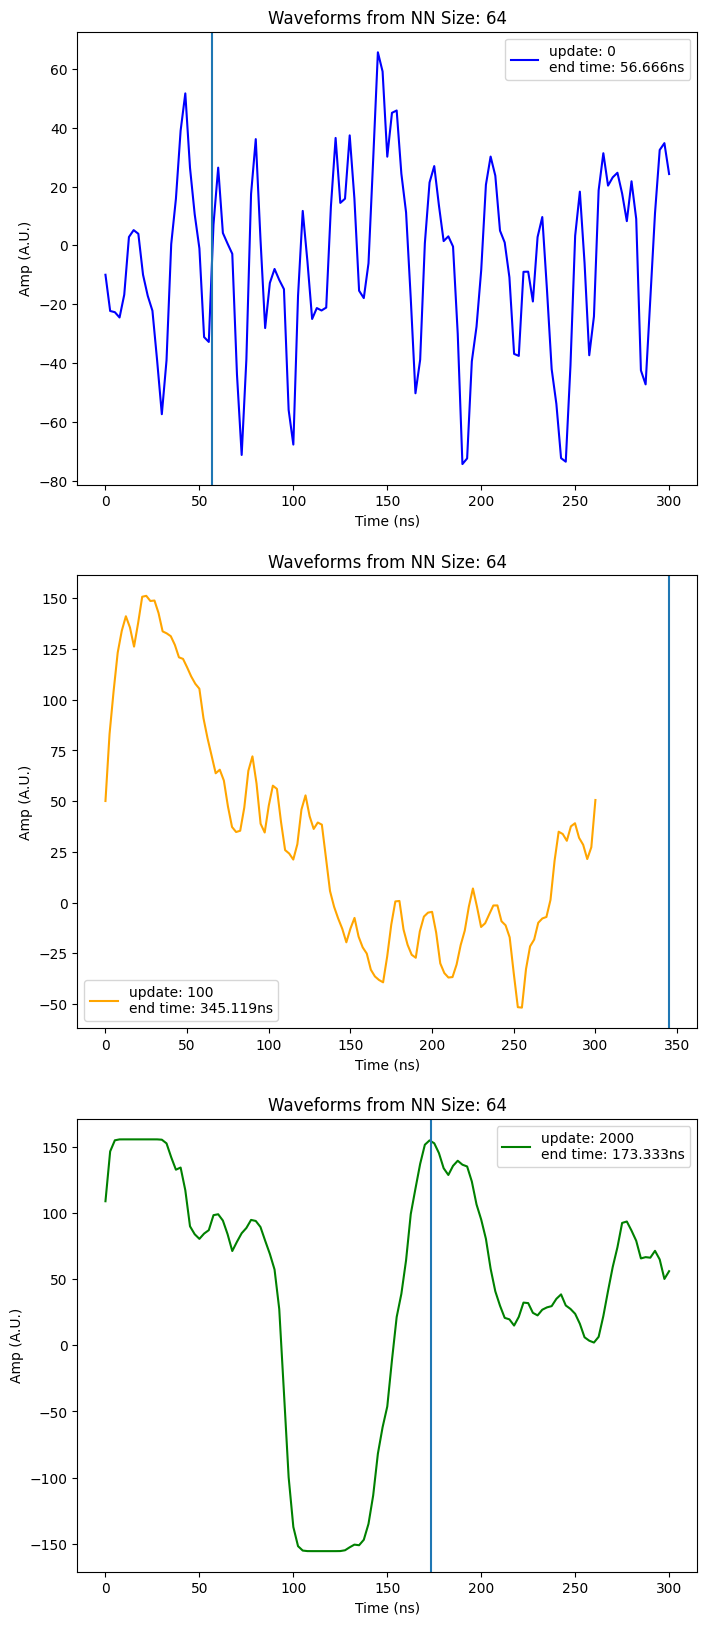

In [32]:
# Visualising Waveform Learning

plotting_updates = np.array([0, 100, 2000], dtype=np.int16)

print(max_actions.shape)

update_action = -max_actions[plotting_updates, 0]
action_linspace = np.linspace(0., num_t1 / kappa, update_action.shape[-1])

fig, ax = plt.subplots(len(plotting_updates), figsize=(8.0, 20.0))

color_list = ["blue", "orange", "green"]

for ind, action in enumerate(update_action):
    ax[ind].plot(action_linspace * 1e3, action, label=f'update: {plotting_updates[ind]}\nend time: {int(1e6 * max_times[plotting_updates[ind], 0]) / 1e3}ns', color=color_list[ind])
    ax[ind].axvline(x=1e6 * max_times[plotting_updates[ind], 0] / 1e3)
    print(max_times[plotting_updates[ind], 0])
    ax[ind].legend()
    ax[ind].set_xlabel('Time (ns)')
    ax[ind].set_ylabel('Amp (A.U.)')
    ax[ind].set_title(f'Waveforms from NN Size: {config["LAYER_SIZE"]}')
plt.show()

In [34]:
# Running Action in Env

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [60]:
action = -update_action[-1] * jnp.heaviside(0.174 - env.ts_action, 1.0)
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
) = env.batched_extract_values(batched_res, batched_action)

0.0952957740904139
208
0.3949677954919565
156


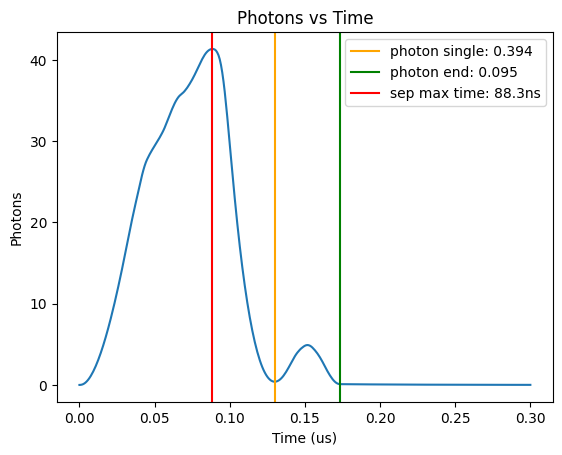

In [76]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)

ext = 50
ext_15 = 200
ext_2 = 209

min_photon = jnp.min(single_photon[ext:ext_2])
argmin = jnp.argmin(single_photon[ext:ext_2]) + ext

min_photon_2 = jnp.min(single_photon[ext:ext_15])
argmin_2 = jnp.argmin(single_photon[ext:ext_15]) + ext

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.legend()
plt.show()

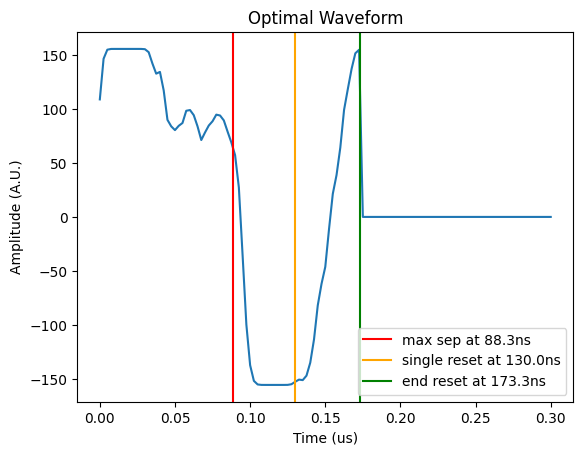

In [78]:
plt.plot(env.ts_action, -action)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

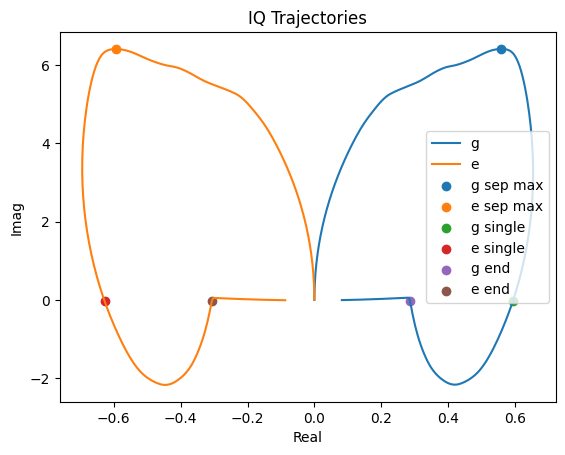

In [79]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()